<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

**CONTESTO:** Rock o Hip-Hop? Applica metodi di machine learning per classificare i brani in generi musicali, senza doverli ascoltare :) 

**OBIETTIVO:** 

Utilizzando un set di dati composto da brani di due generi musicali (Hip-Hop e Rock), addestrerai un classificatore per distinguere tra i due generi in base solo alle informazioni sui brani derivate dai dati che hai a disposizione. Per prima cosa utilizzerai Pandas per analizzare i dati, aggregare informazioni e creare grafici con Seaborn o MatplotLib.

Successivamente, utilizzerai la libreria scikit-learn per prevedere se puoi classificare correttamente il genere di una canzone in base a caratteristiche come energia, acustica, tempo, ballabilità etc..


**Dati a disposizione:**

Qui puoi trovare due fonti dati, uno in formato csv e l'altro in formato json.

https://drive.google.com/drive/folders/1vPd0qBCpWm_QEXM5NRynNrs72-pUuhSn?usp=sharing

In [146]:
#Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn import tree
from dtreeviz.trees import *
import warnings

warnings.filterwarnings('ignore')

In [147]:
dataset = pd.read_csv('dataset.csv')
metrics = pd.read_json('metrics.json')

In [148]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17734 entries, 0 to 17733
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_id       17734 non-null  int64 
 1   bit_rate       17734 non-null  int64 
 2   comments       17734 non-null  int64 
 3   composer       166 non-null    object
 4   date_created   17734 non-null  object
 5   date_recorded  1898 non-null   object
 6   duration       17734 non-null  int64 
 7   favorites      17734 non-null  int64 
 8   genre_top      17734 non-null  object
 9   genres         17734 non-null  object
 10  genres_all     17734 non-null  object
 11  information    482 non-null    object
 12  interest       17734 non-null  int64 
 13  language_code  4089 non-null   object
 14  license        17714 non-null  object
 15  listens        17734 non-null  int64 
 16  lyricist       53 non-null     object
 17  number         17734 non-null  int64 
 18  publisher      52 non-null

In [149]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          13129 non-null  int64  
 1   acousticness      13129 non-null  float64
 2   danceability      13129 non-null  float64
 3   energy            13129 non-null  float64
 4   instrumentalness  13129 non-null  float64
 5   liveness          13129 non-null  float64
 6   speechiness       13129 non-null  float64
 7   tempo             13129 non-null  float64
 8   valence           13129 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [150]:
dataset['genre_top'].value_counts()

Rock       14182
Hip-Hop     3552
Name: genre_top, dtype: int64

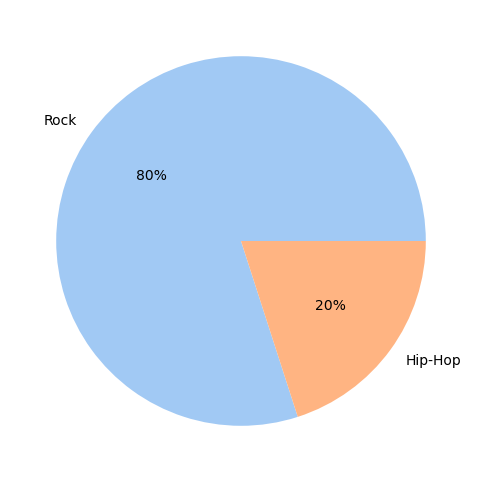

In [151]:
#Target population balance

plt.figure(figsize = (15,6))

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#define labels
labels = ['Rock','Hip-Hop']

#create pie chart
plt.pie(dataset['genre_top'].value_counts(), labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

La colonna genre_top assegna ad ogni brano musicale un'etichetta di genere Rock oppure Hip-Hop. E' utile notare che le popolazioni sono nettamente sbilanciate a favore dei brani rock (80% vs 20%). Questo andrà considerato successivamente, poichè gli alberi decisionali non si comportano generalmente bene nel caso di popolazioni sbilanciate.

### Data Cleaning

In [152]:
# Merge the two datasets

music = pd.merge(dataset, metrics, on=['track_id'], how='inner') 

In [153]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   bit_rate          4802 non-null   int64  
 2   comments          4802 non-null   int64  
 3   composer          106 non-null    object 
 4   date_created      4802 non-null   object 
 5   date_recorded     1234 non-null   object 
 6   duration          4802 non-null   int64  
 7   favorites         4802 non-null   int64  
 8   genre_top         4802 non-null   object 
 9   genres            4802 non-null   object 
 10  genres_all        4802 non-null   object 
 11  information       334 non-null    object 
 12  interest          4802 non-null   int64  
 13  language_code     2599 non-null   object 
 14  license           4789 non-null   object 
 15  listens           4802 non-null   int64  
 16  lyricist          13 non-null     object 


In [154]:
#Drop columns

music = music.drop(['comments','composer','date_created','date_recorded','genres',
                        'genres_all','information','language_code','license','lyricist',
                        'publisher','tags','title'],axis=1)

In [155]:
music.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   bit_rate          4802 non-null   int64  
 2   duration          4802 non-null   int64  
 3   favorites         4802 non-null   int64  
 4   genre_top         4802 non-null   object 
 5   interest          4802 non-null   int64  
 6   listens           4802 non-null   int64  
 7   number            4802 non-null   int64  
 8   acousticness      4802 non-null   float64
 9   danceability      4802 non-null   float64
 10  energy            4802 non-null   float64
 11  instrumentalness  4802 non-null   float64
 12  liveness          4802 non-null   float64
 13  speechiness       4802 non-null   float64
 14  tempo             4802 non-null   float64
 15  valence           4802 non-null   float64
dtypes: float64(8), int64(7), object(1)
memory 

### Encoding

In [156]:
label = music['genre_top']

label_encoder = LabelEncoder()
music['label'] = label_encoder.fit_transform(label)
music = music.drop(['genre_top'],axis=1)

In [157]:
#Heat map Correlation matrix

fig = px.imshow(music.corr(),x=list(music.corr().columns),y=list(music.corr().columns),width=800, height=800)
fig.show()

Dalla matrice di correlazione si nota che la feature 'listens' è fortemente correlata con la feature 'interest'. Per questo motivo decidiamo di rimuovere la priam feature mantenendo la seconda.

In [158]:
#Drop columns

music = music.drop(['listens'],axis=1)

In [159]:
#Heat map Correlation matrix

fig = px.imshow(music.corr(),x=list(music.corr().columns),y=list(music.corr().columns),width=800, height=800)
fig.show()

In [160]:
music.head()

track_id  bit_rate  duration  favorites  interest  number  acousticness  \
0       153    256000       405          5       354       2      0.988306   
1       154    256000       319          1       242       4      0.970135   
2       155    192000       756          1       268       0      0.981657   
3       169    192000       144          1       815       1      0.989141   
4       170    192000       181          0       468       2      0.886660   

   danceability    energy  instrumentalness  liveness  speechiness   tempo  \
0      0.255661  0.979774          0.973006  0.121342     0.051740  90.241   
1      0.352946  0.023852          0.957113  0.113261     0.032177  53.758   
2      0.142249  0.912122          0.967294  0.363510     0.087527  91.912   
3      0.225978  0.722835          0.263076  0.092371     0.053406  94.322   
4      0.298518  0.744333          0.920950  0.139587     0.088781  97.880   

    valence  label  
0  0.034018      1  
1  0.035632      1  
2  0.034325      1  
3  0.028347      1  
4  0.073548      1

In [161]:
#Create scatter matrix from dataframe

#colors = ['red' if label == 1 else 'black' for label in music['label']]
#pd.plotting.scatter_matrix(music, figsize=(30,30), c=colors,
                           #marker='o',hist_kwds={'color':['burlywood'],'bins':15}, s=3);
    
sns.pairplot(music, hue='label', palette="YlGnBu")

# display plot
plt.show()

Dal pairplot precedente è possibile notare che alcune feature sono più importanti di altre perchè più selettive. Per esempio dagli istogrammi è chiaramente visibile che i brani hip hop sono generalmente caratterizzati da una speechiness più alta e anche da una danceability maggiore rispetto ai brani rock. Anche tempo e valence sembrano due feature rilevanti in quanto i picchi degli istogrammi delle due popolazioni hip hop e rock sono sfasati

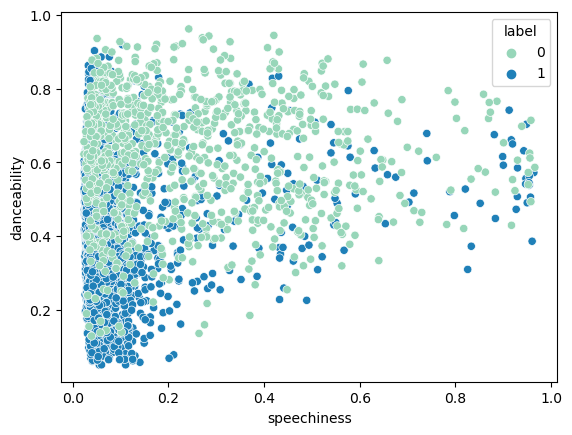

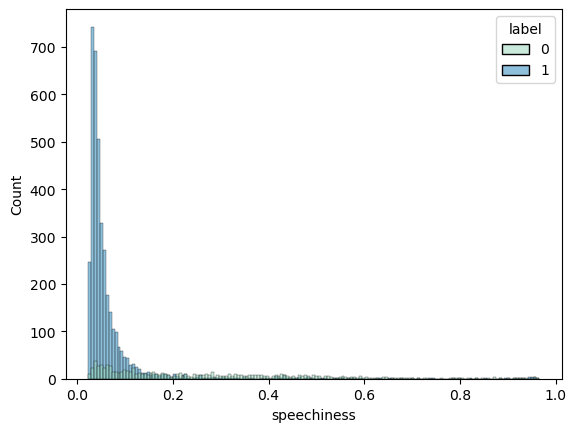

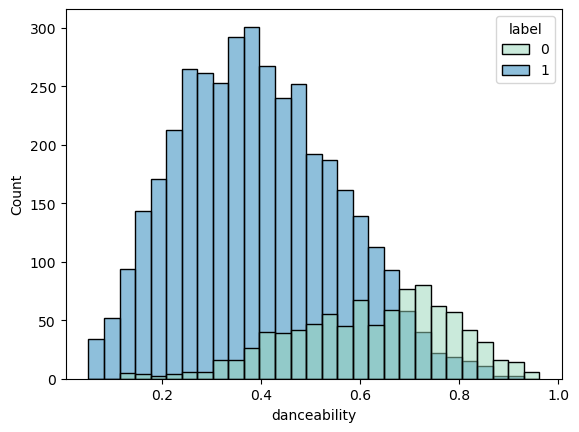

In [162]:
sns.scatterplot(data=music, x='speechiness', y='danceability', hue='label', palette="YlGnBu")
plt.show()
sns.histplot(data=music, x='speechiness',hue='label', palette="YlGnBu")
plt.show()
sns.histplot(data=music, x='danceability',hue='label', palette="YlGnBu")
plt.show()

In [163]:
# Suddivisione fra features e label

features = ['track_id', 'bit_rate','duration','favorites','interest','number','acousticness','danceability',
           'energy','instrumentalness','liveness','speechiness','tempo','valence']
label = ['label']

# labels

y = music[label]
X = music[features]

### Separazione fra train e test set

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=42)

### Decision Tree Classifier

In [165]:
weights = {0:0.8, 1:0.2} #i pesi servono a compensare lo sbilanciamento fra le due popolazioni target
dt = DecisionTreeClassifier(class_weight=weights, random_state=44)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76        91
           1       0.94      0.95      0.94       390

    accuracy                           0.91       481
   macro avg       0.86      0.85      0.85       481
weighted avg       0.91      0.91      0.91       481



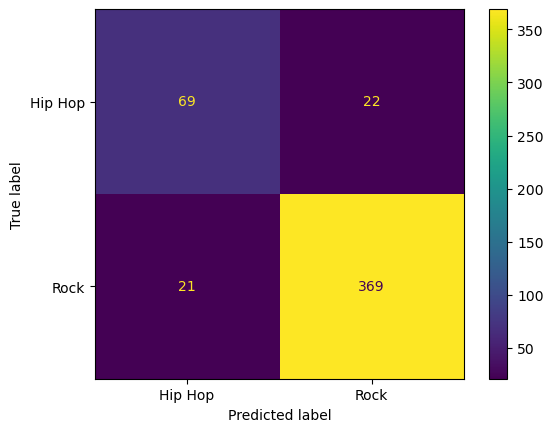

In [166]:
#Create and plot confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Hip Hop', 'Rock'])
cm_display.plot()
plt.show()

In [167]:
#weights = {0:0.8, 1:0.2}
dt = DecisionTreeClassifier(class_weight=weights,splitter='best', max_depth=7, max_leaf_nodes=40, random_state=44)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        91
           1       0.97      0.95      0.96       390

    accuracy                           0.94       481
   macro avg       0.89      0.92      0.90       481
weighted avg       0.94      0.94      0.94       481



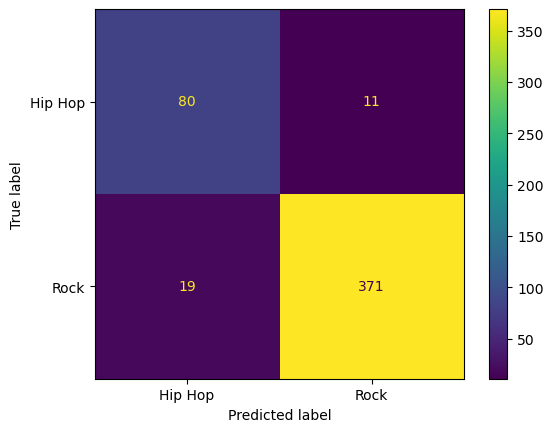

In [168]:
#Create and plot confusion matrix

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Hip Hop', 'Rock'])
cm_display.plot()
plt.show()

Limitando il numero di rami a 8 abbiamo massimizzato i valori di f1 score che passano da 0.78 a 0.83 per la classe 0 (Hip Hop) e da 0.95 a 0.96 per la classe 1 (Rock)

In [169]:
# Visualize Decision Tree

fig = plt.figure(figsize=(30,20))
tree.plot_tree(dt, feature_names=X.columns, class_names=['Hip Hop','Rock'],filled=True);

In [170]:
#Visualise Decision Tree

#viz = dtreeviz(dt, np.array(X), np.array(y).reshape(-1), target_name='label',
               #feature_names=['track_id', 'bit_rate','duration','favorites','interest','number','acousticness','danceability',                                                                                          
               #'energy','instrumentalness','liveness','speechiness','tempo','valence'], class_names={0:'Hip Hop',1:'Rock'})

#viz

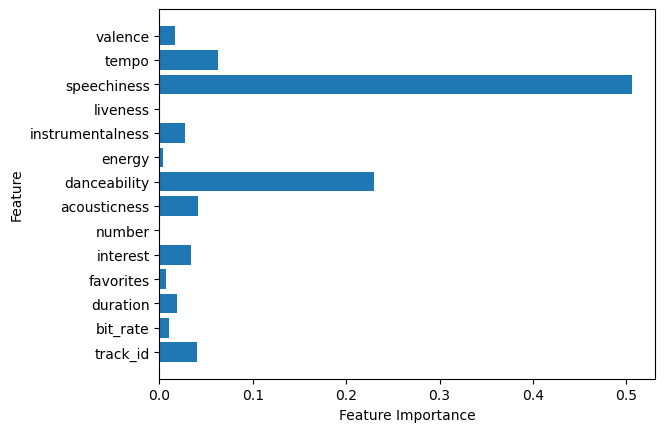

In [171]:
#Feature Importance
n_features = X.shape[1]
plt.barh(np.arange(n_features),dt.feature_importances_);
plt.yticks(np.arange(n_features), X.columns);
plt.xlabel('Feature Importance');
plt.ylabel('Feature');
plt.show()

Il grafico a barre qui sopra indica l'importanza che il classificatore ha dato alle diverse features all'interno dell'albero decisionale. Come già notato ancora prima della costruzione dell'albero decisionale, le feature più importanti sono anche quelle più selettive, ovvero speechiness e danceability su tutte. Acousticness, Tempo, valence e track_id sono importanti in minor misura.

### Appendice: Decision Tree Hyperparameter analysis

Di seguito vengono analizzati l'impatto di alcuni fra i più utilizzati iperparameteri della classe DecisionTreeClassifier sull'accuratezza del train e del test set. L'effetto di ogni iperparametro viene analizzato singolarmente, nell'analisi non è stato considerato l'effetto combinato di più iperparametri assieme.


In [172]:
#Setup arrays to store training and test accuracies
max_depth = np.arange(1,50)
train_accuracy =np.empty(len(max_depth))
test_accuracy = np.empty(len(max_depth))
weights = {0:0.8, 1:0.2}

for i,k in enumerate(max_depth):
    #Setup a decision tree classifier
    dt = DecisionTreeClassifier(class_weight=weights, max_depth=k, random_state=44)
    
    #Fit the model
    dt.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = dt.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = dt.score(X_test, y_test) 
    
#create DataFrame
df_accuracy = pd.DataFrame({'max_depth': max_depth,
                   'train_accuracy': train_accuracy,
                   'test_accuracy': test_accuracy})

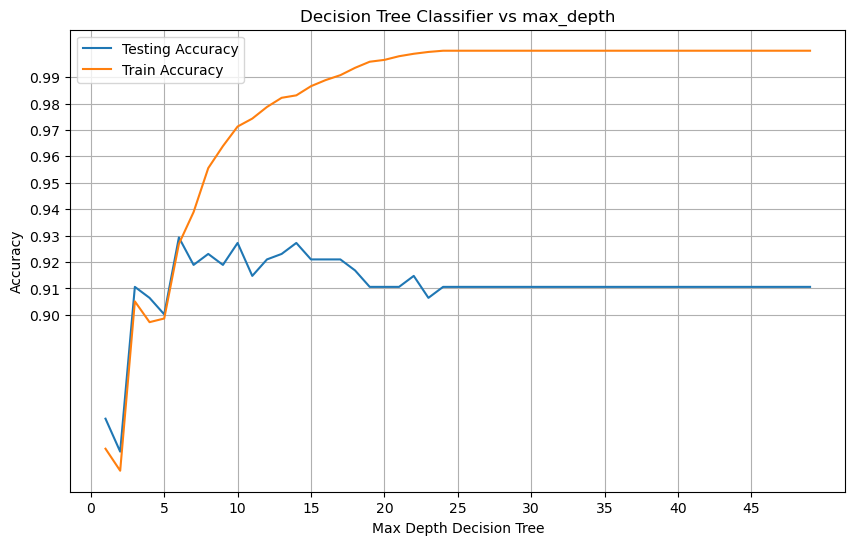

In [173]:
#Generate plot
plt.figure(figsize=(10,6))

plt.title('Decision Tree Classifier vs max_depth')
sns.lineplot(data=df_accuracy, x=max_depth, y=test_accuracy, label='Testing Accuracy')
sns.lineplot(data=df_accuracy, x=max_depth, y=train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Max Depth Decision Tree')
plt.ylabel('Accuracy')

# set the tick locations manually
x_ticks = np.arange(0, 50, 5)
y_ticks = np.arange(0.9,1,0.01)

# set the tick labels
x_tick_labels = ['%d' % x for x in x_ticks]
y_tick_labels = ['%.2f' % y for y in y_ticks]

# set the tick locations and labels
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

# display the grid lines
plt.grid(True)

plt.show()

Il parametro Max Depth definisce la profondità massima dell'albero decisionale limitando il numero di livelli possibili. Dal grafico sopra risulta evidente che all'aumentare della profondità dell'albero, il modello diventa più complesso e l'accuratezza sui dati di training aumenta portando all'overfitting. I valori ottimali dell'iperparametro max_depth stanno fra i 5 e 10 in coincidenza di un massimo dell'accuratezza sui dati di test.

In [174]:
#Setup arrays to store training and test accuracies
max_leaf_nodes = np.arange(2,200)
train_accuracy =np.empty(len(max_leaf_nodes))
test_accuracy = np.empty(len(max_leaf_nodes))
weights = {0:0.8, 1:0.2}

for i,k in enumerate(max_leaf_nodes):
    #Setup a decision tree classifier
    dt = DecisionTreeClassifier(class_weight=weights,max_leaf_nodes=k, random_state=44)
    
    #Fit the model
    dt.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = dt.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = dt.score(X_test, y_test) 
    
#create DataFrame
df_accuracy = pd.DataFrame({'max_leaf_nodes': max_leaf_nodes,
                   'train_accuracy': train_accuracy,
                   'test_accuracy': test_accuracy})

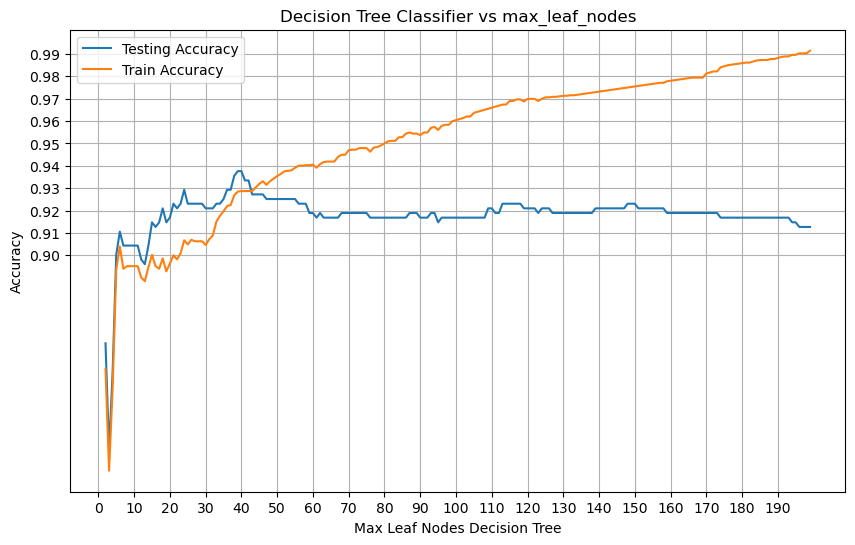

In [175]:
#Generate plot
plt.figure(figsize=(10,6))

plt.title('Decision Tree Classifier vs max_leaf_nodes')
sns.lineplot(data=df_accuracy, x=max_leaf_nodes, y=test_accuracy, label='Testing Accuracy')
sns.lineplot(data=df_accuracy, x=max_leaf_nodes, y=train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Max Leaf Nodes Decision Tree')
plt.ylabel('Accuracy')

# set the tick locations manually
x_ticks = np.arange(0, 200, 10)
y_ticks = np.arange(0.9,1,0.01)

# set the tick labels
x_tick_labels = ['%d' % x for x in x_ticks]
y_tick_labels = ['%.2f' % y for y in y_ticks]

# set the tick locations and labels
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

# display the grid lines
plt.grid(True)

plt.show()

L'iperparametro max_leaf_nodes definisce il numero massimo di nodi leaf presenti all'interno dell'albero decisionale. Dall'analisi del grafico è evidente che all'aumentare del numero massimo di nodi leaf il modello cresce di complessità, la train accuracy tende a 1 e il modello va in overfitting. Un valore ottimale dell'iperparametro sta nel range 20-80.

In [176]:
#Setup arrays to store training and test accuracies
min_samples_split = np.arange(2,200)
train_accuracy =np.empty(len(min_samples_split))
test_accuracy = np.empty(len(min_samples_split))
weights = {0:0.8, 1:0.2}

for i,k in enumerate(min_samples_split):
    #Setup a decision tree classifier
    dt = DecisionTreeClassifier(class_weight=weights,min_samples_split=k, random_state=44)
    
    #Fit the model
    dt.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = dt.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = dt.score(X_test, y_test) 
    
#create DataFrame
df_accuracy = pd.DataFrame({'min_samples_split': min_samples_split,
                   'train_accuracy': train_accuracy,
                   'test_accuracy': test_accuracy})

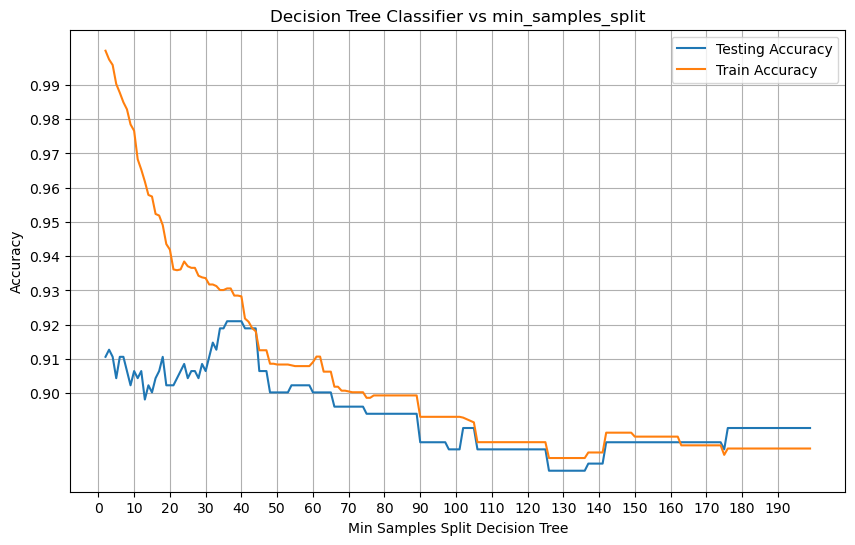

In [177]:
#Generate plot
plt.figure(figsize=(10,6))

plt.title('Decision Tree Classifier vs min_samples_split')
sns.lineplot(data=df_accuracy, x=min_samples_split, y=test_accuracy, label='Testing Accuracy')
sns.lineplot(data=df_accuracy, x=min_samples_split, y=train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Min Samples Split Decision Tree')
plt.ylabel('Accuracy')

# set the tick locations manually
x_ticks = np.arange(0, 200, 10)
y_ticks = np.arange(0.9,1,0.01)

# set the tick labels
x_tick_labels = ['%d' % x for x in x_ticks]
y_tick_labels = ['%.2f' % y for y in y_ticks]

# set the tick locations and labels
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

# display the grid lines
plt.grid(True)

plt.show()

L'iperparametro min_samples_split definisce il minimo numero di samples per ogni split. E' chiaro che se il valore è molto piccolo il modello tende ad essere più complicato e tende all'overfitting come intuibile dagli alti valori della train accuracy.

In [178]:
#Setup arrays to store training and test accuracies
max_features = np.arange(1,14)
train_accuracy =np.empty(len(max_features))
test_accuracy = np.empty(len(max_features))
weights = {0:0.8, 1:0.2}

for i,k in enumerate(max_features):
    #Setup a decision tree classifier
    dt = DecisionTreeClassifier(class_weight=weights, max_features=k, random_state=44)
    
    #Fit the model
    dt.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = dt.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = dt.score(X_test, y_test) 
    
#create DataFrame
df_accuracy = pd.DataFrame({'max_leaf_nodes': max_features,
                   'train_accuracy': train_accuracy,
                   'test_accuracy': test_accuracy})

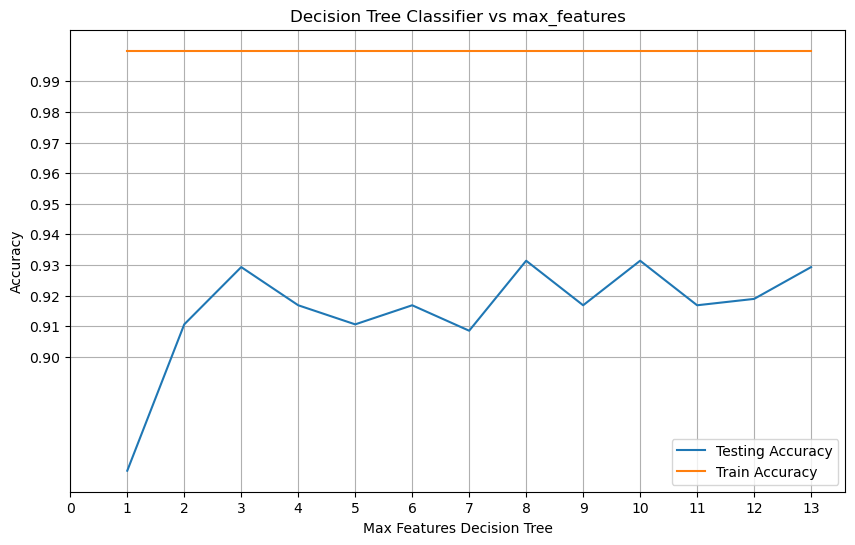

In [179]:
#Generate plot
plt.figure(figsize=(10,6))

plt.title('Decision Tree Classifier vs max_features')
sns.lineplot(data=df_accuracy, x=max_features, y=test_accuracy, label='Testing Accuracy')
sns.lineplot(data=df_accuracy, x=max_features, y=train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Max Features Decision Tree')
plt.ylabel('Accuracy')

# set the tick locations manually
x_ticks = np.arange(0, 14, 1)
y_ticks = np.arange(0.9,1,0.01)

# set the tick labels
x_tick_labels = ['%d' % x for x in x_ticks]
y_tick_labels = ['%.2f' % y for y in y_ticks]

# set the tick locations and labels
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

# display the grid lines
plt.grid(True)

plt.show()

L'iperparametro max_features definisce il numero massimo di features utilizzate nella costruzione dell'albero decisionale. E' interessante notare che nel caso considerato, l'iperparametro non ha la minima influenza sulla train accuracy.

In [180]:
#Setup arrays to store training and test accuracies
min_impurity_decrease = np.arange(0,0.15,0.001)
train_accuracy =np.empty(len(min_impurity_decrease))
test_accuracy = np.empty(len(min_impurity_decrease))
weights = {0:0.8, 1:0.2}

for i,k in enumerate(min_impurity_decrease):
    #Setup a decision tree classifier
    dt = DecisionTreeClassifier(class_weight=weights,min_impurity_decrease=k, random_state=44)
    
    #Fit the model
    dt.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = dt.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = dt.score(X_test, y_test) 
    
#create DataFrame
df_accuracy = pd.DataFrame({'min_impurity_decrease': min_impurity_decrease,
                   'train_accuracy': train_accuracy,
                   'test_accuracy': test_accuracy})

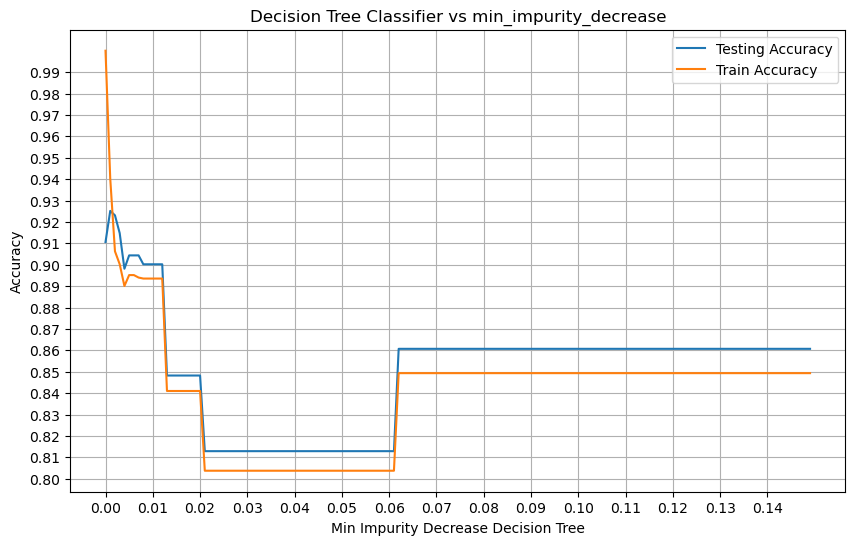

In [181]:
#Generate plot
plt.figure(figsize=(10,6))

plt.title('Decision Tree Classifier vs min_impurity_decrease')
sns.lineplot(data=df_accuracy, x=min_impurity_decrease, y=test_accuracy, label='Testing Accuracy')
sns.lineplot(data=df_accuracy, x=min_impurity_decrease, y=train_accuracy, label='Train Accuracy')
plt.legend()
plt.xlabel('Min Impurity Decrease Decision Tree')
plt.ylabel('Accuracy')

# set the tick locations manually
x_ticks = np.arange(0, 0.15, 0.01)
y_ticks = np.arange(0.8,1,0.01)

# set the tick labels
x_tick_labels = ['%.2f' % x for x in x_ticks]
y_tick_labels = ['%.2f' % y for y in y_ticks]

# set the tick locations and labels
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)

# display the grid lines
plt.grid(True)

plt.show()

L'iperparametro min_impurity_decrease definisce il minimo decremento di impurità calcolato ad ogni nodo dell'albero decisionale. L'impurità può essere calcolata tramite l'entropia o il coefficiente di Gini. E' interessante notare che valori molto bassi dell'iperparametro tendono a rendere il modello troppo complesso portando all'overfitting. D'altro canto valori molto alti dell'iperparametro tendono a ridurre l'accuratezza dell'algoritmo e al conseguente underfitting dovuto all'ipersemplificazione del modello.

unbalanced classification

https://machinelearningmastery.com/cost-sensitive-decision-trees-for-imbalanced-classification/#:~:text=The%20decision%20tree%20algorithm%20is,two%20groups%20with%20minimum%20mixing.